<a href="https://colab.research.google.com/github/Sruthij93/BrainTumorClassification_model/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 140M/149M [00:00<00:00, 184MB/s]
100% 149M/149M [00:00<00:00, 175MB/s]


In [3]:
def get_class_paths(path):
  classes = []
  class_paths = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # check if label path is a directory
    if os.path.isdir(label_path):
      # iterate through the images in the directory and form the path
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        # add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # create a dataframe with classpath and labels
  df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
  return df


In [4]:
tr_df = get_class_paths('/content/Training')


In [5]:
tr_df

,Class Path,Class
0,/content/Training/pituitary/Tr-pi_0519.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_0615.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_1262.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0056.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_0571.jpg,pituitary
...,...,...
5707,/content/Training/glioma/Tr-gl_0398.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0351.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0998.jpg,glioma
5710,/content/Training/glioma/Tr-gl_1045.jpg,glioma


In [6]:
ts_df = get_class_paths("/content/Testing")

In [7]:
ts_df

,Class Path,Class
0,/content/Testing/pituitary/Te-pi_0066.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0231.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0190.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0016.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0261.jpg,pituitary
...,...,...
1306,/content/Testing/glioma/Te-gl_0207.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0205.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0139.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0215.jpg,glioma


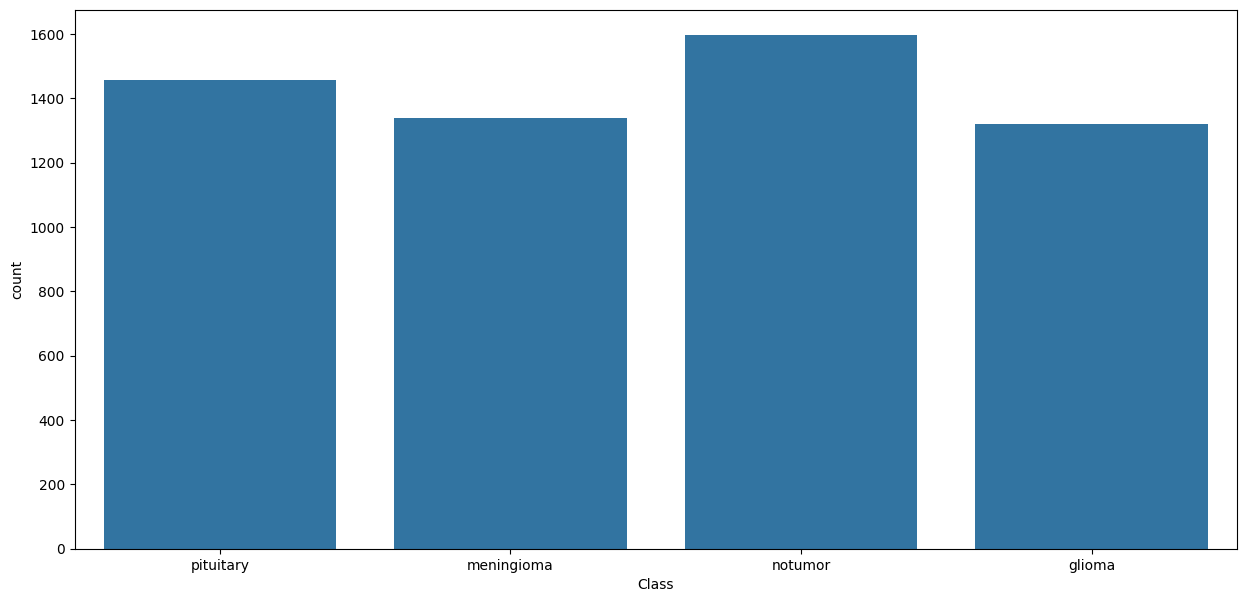

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])
plt.show()

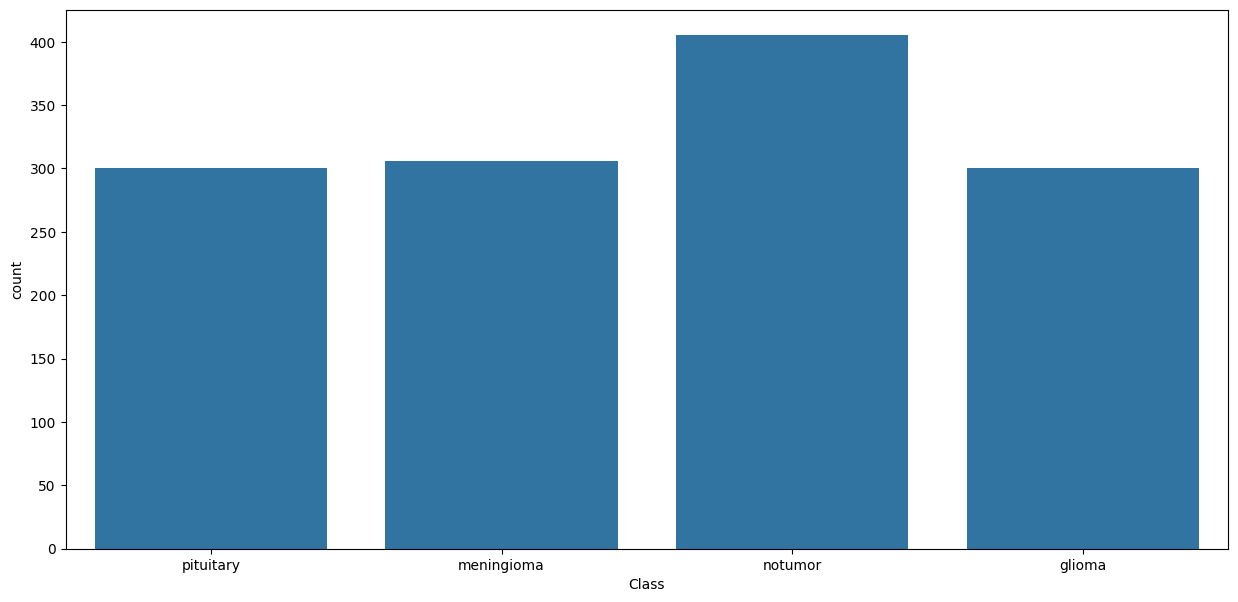

In [9]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
# set aside part of test dataset to test and validation dataset
valid_df, ts_df = train_test_split(ts_df, train_size = 0.5, stratify = ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
74,/content/Testing/pituitary/Te-pi_0083.jpg,pituitary
640,/content/Testing/notumor/Te-no_0014.jpg,notumor
905,/content/Testing/notumor/Te-no_0052.jpg,notumor
306,/content/Testing/meningioma/Te-me_0048.jpg,meningioma
601,/content/Testing/meningioma/Te-me_0191.jpg,meningioma
...,...,...
1110,/content/Testing/glioma/Te-gl_0290.jpg,glioma
1082,/content/Testing/glioma/Te-gl_0268.jpg,glioma
96,/content/Testing/pituitary/Te-pi_0149.jpg,pituitary
183,/content/Testing/pituitary/Te-piTr_0008.jpg,pituitary


In [13]:
ts_df

,Class Path,Class
904,/content/Testing/notumor/Te-no_0086.jpg,notumor
542,/content/Testing/meningioma/Te-me_0207.jpg,meningioma
846,/content/Testing/notumor/Te-no_0382.jpg,notumor
685,/content/Testing/notumor/Te-no_0073.jpg,notumor
778,/content/Testing/notumor/Te-no_0314.jpg,notumor
...,...,...
366,/content/Testing/meningioma/Te-me_0259.jpg,meningioma
696,/content/Testing/notumor/Te-no_0144.jpg,notumor
271,/content/Testing/pituitary/Te-pi_0207.jpg,pituitary
140,/content/Testing/pituitary/Te-pi_0081.jpg,pituitary


In [14]:
# Preprocess the data
batch_size = 32 # size of data to process at once. (16,32,64,128 - common values)

# resize the images to same size (same dims)
img_size = (299,299)

# easily preprocess the images by rescaling the pixel values and adjusting brightness (more robust and generalize to new data)
image_generator = ImageDataGenerator(rescale = 1/255, brightness_range = (0.8, 1.2))

# we do not change the brightness for the test data so data is consistent and does not randomly adjust the brightness.
ts_gen = ImageDataGenerator(rescale = 1/255)

In [15]:
# create 3 dataflows: take image data from dataframes and prep them to be fed into the datamodel
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

ts_fen = ts_gen.flow_from_dataframe(ts_df, x_col = "Class Path", y_col = "Class", batch_size = 16, target_size = img_size, shuffle= False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


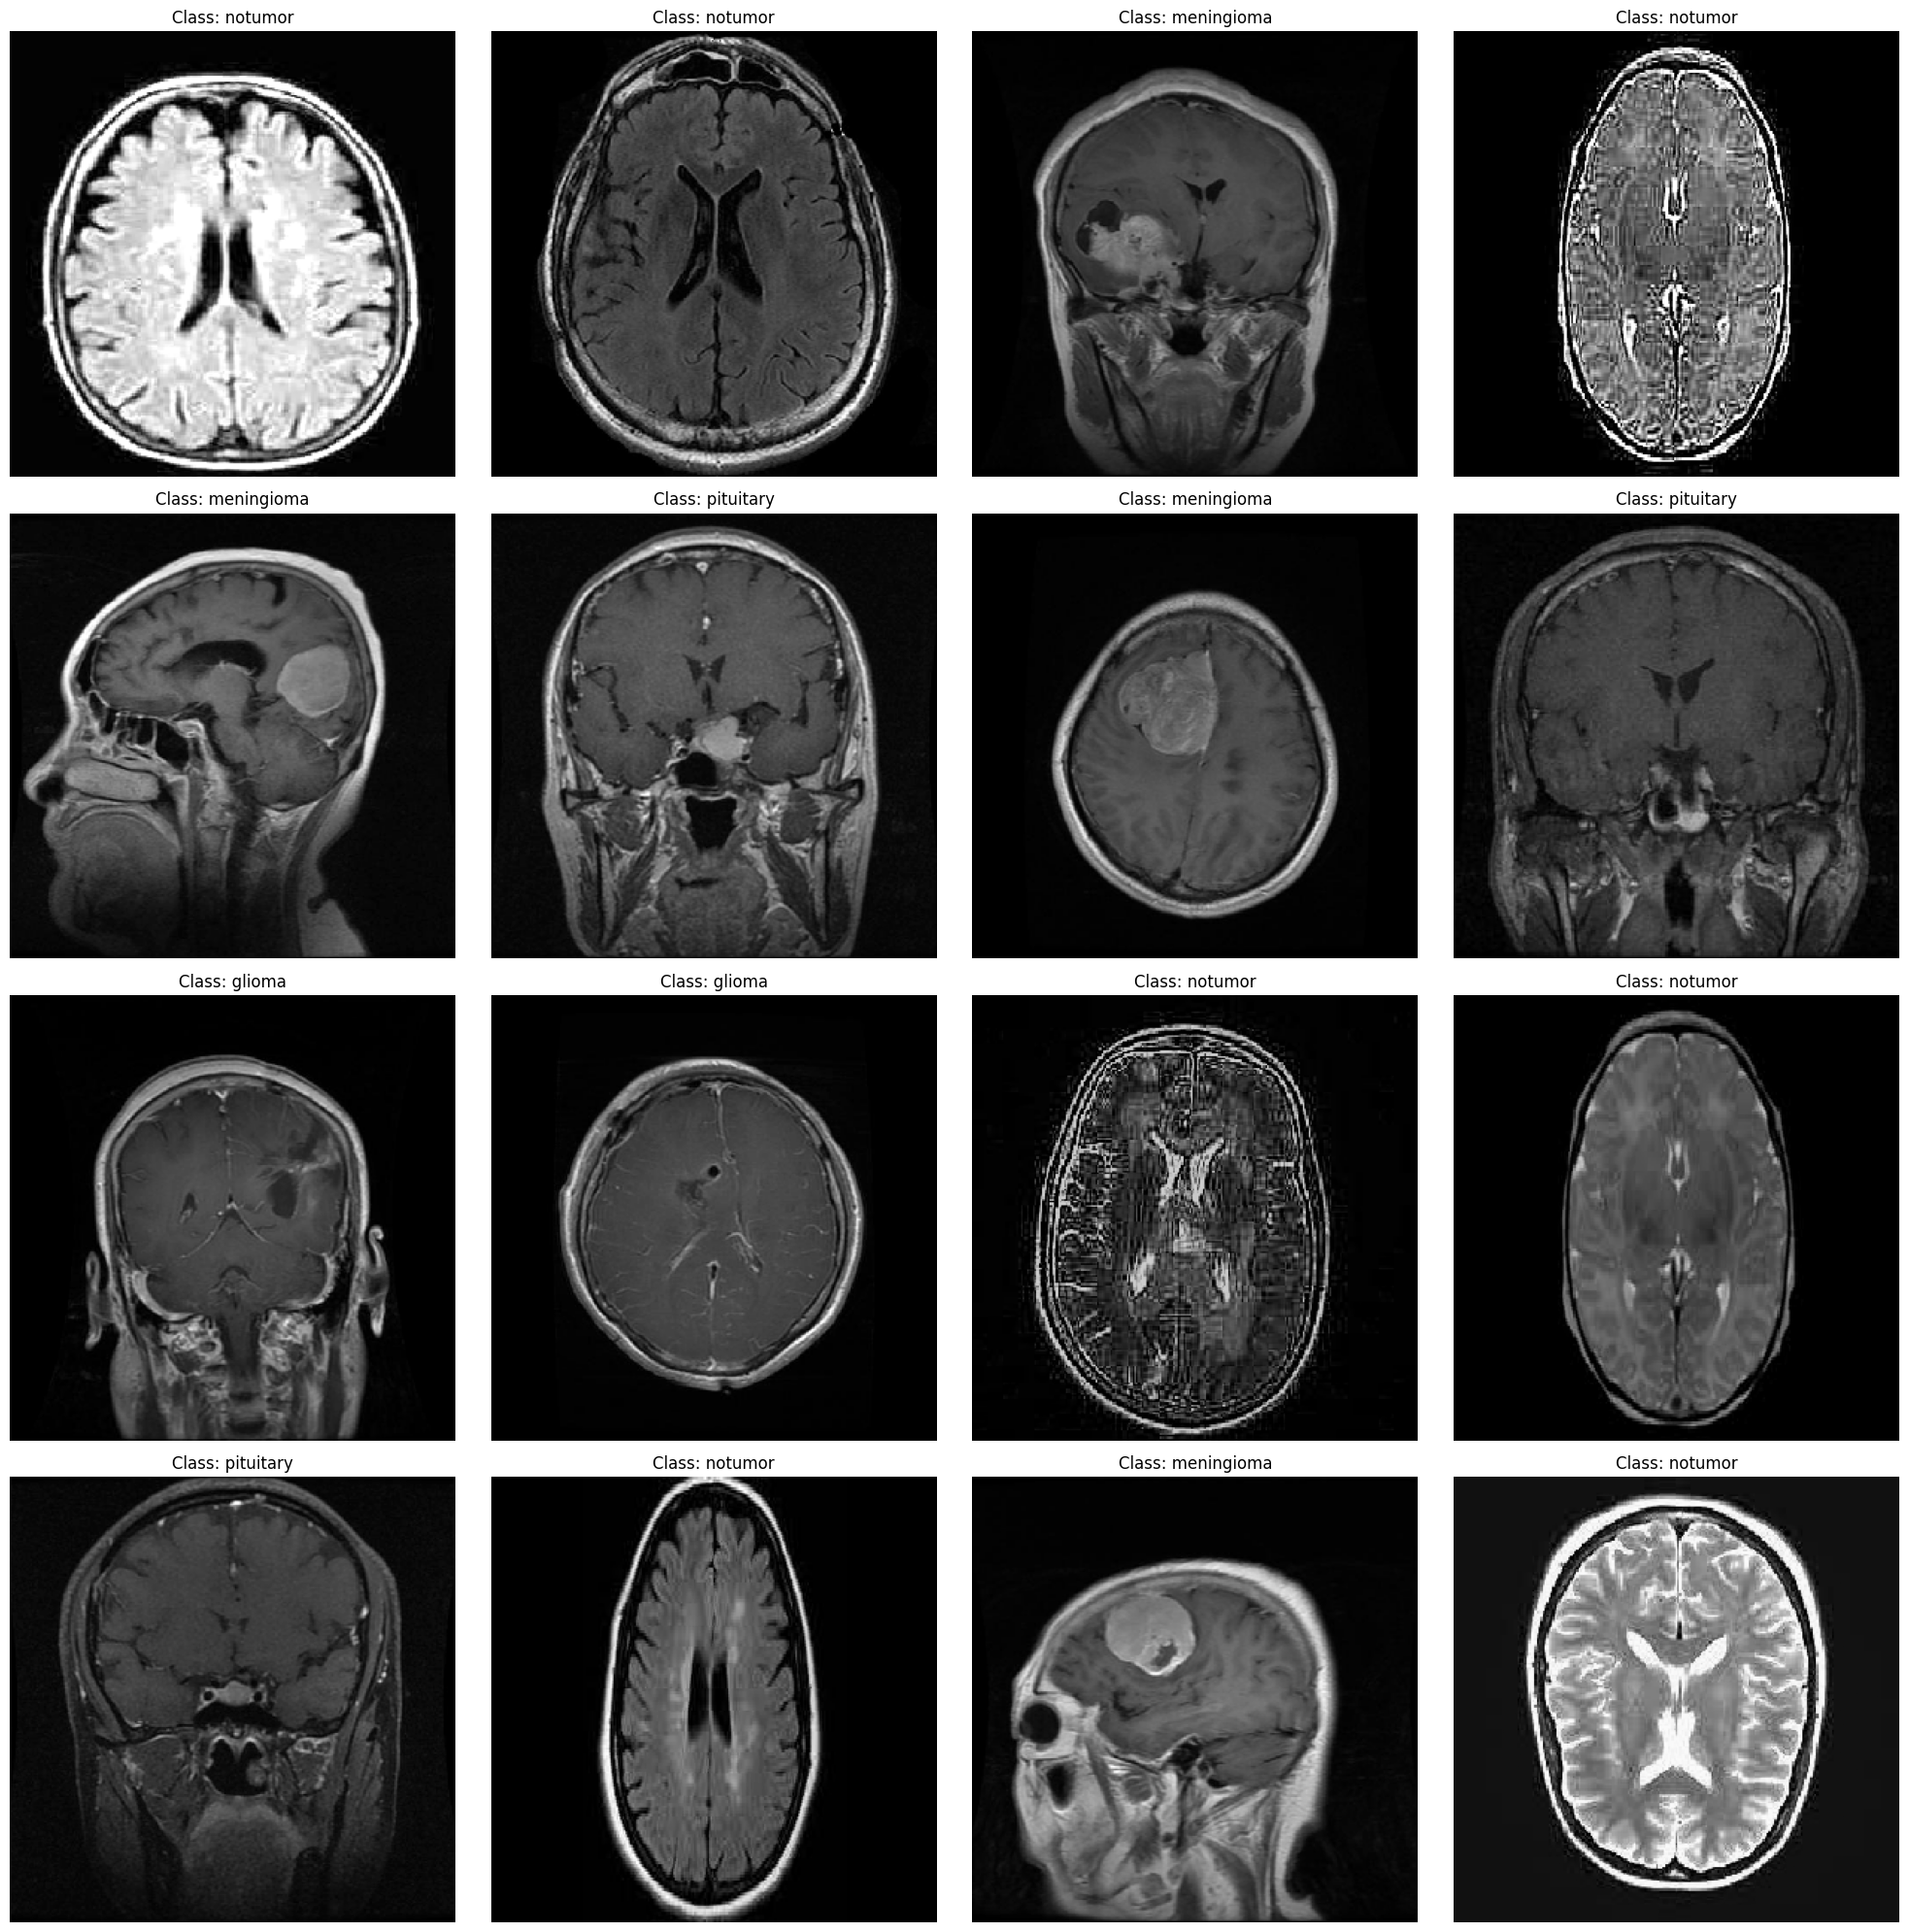

In [16]:
plt.figure(figsize = (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # get the class index
  class_index = np.argmax(label)

  # get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape=img_shape, pooling='max')

# pooling- max looks like at certain sections of the image. Where the feature is at its max standout pixel. Reduces the amount of info to process while still keeping the most important features.

# dropout is to avoid overfitting. randomly drop some of the neurons in the model to help generalize the model to data.
# relu learns the non-linear relationship between the input and output
# softmax takes output from prev layer and outputs the prob of the classes.
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate = 0.3),
    Dense(128, activation ='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
]
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# compile the model
# Adamax- smart asst for the model. Adjusts how big of steps it takes when updating the weights of the model.
# Categorical crossentropy- how much the predicted probabilities differ from the actual probability of each class in the dataset. Penalizes the model heavily for incorrect predictions.

model.compile(Adamax(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ['accuracy', Precision(), Recall()])

In [ ]:
# Train the ML model
hist = model.fit(tr_gen, epochs = 5, validation_data = valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7571 - loss: 0.6883 - precision: 0.8326 - recall: 0.6516 - val_accuracy: 0.9557 - val_loss: 0.1520 - val_precision: 0.9584 - val_recall: 0.9496
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 759ms/step - accuracy: 0.9774 - loss: 0.0741 - precision: 0.9780 - recall: 0.9768 - val_accuracy: 0.8977 - val_loss: 0.3329 - val_precision: 0.9002 - val_recall: 0.8947
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 758ms/step - accuracy: 0.9915 - loss: 0.0353 - precision: 0.9917 - recall: 0.9913 - val_accuracy: 0.9679 - val_loss: 0.0949 - val_precision: 0.9724 - val_recall: 0.9664
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 749ms/step - accuracy: 0.9965 - loss: 0.0143 - precision: 0.9965 - recall: 0.9965 - val_accuracy: 0.9924 - val_loss: 0.0276 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/5
123/179 ━━━━━━━━━━━━━━━━━━━━ 40s 726ms/step - accuracy: 0.9956 - loss: 0.0111 - precision: 0.9957 - recall: 0.9956

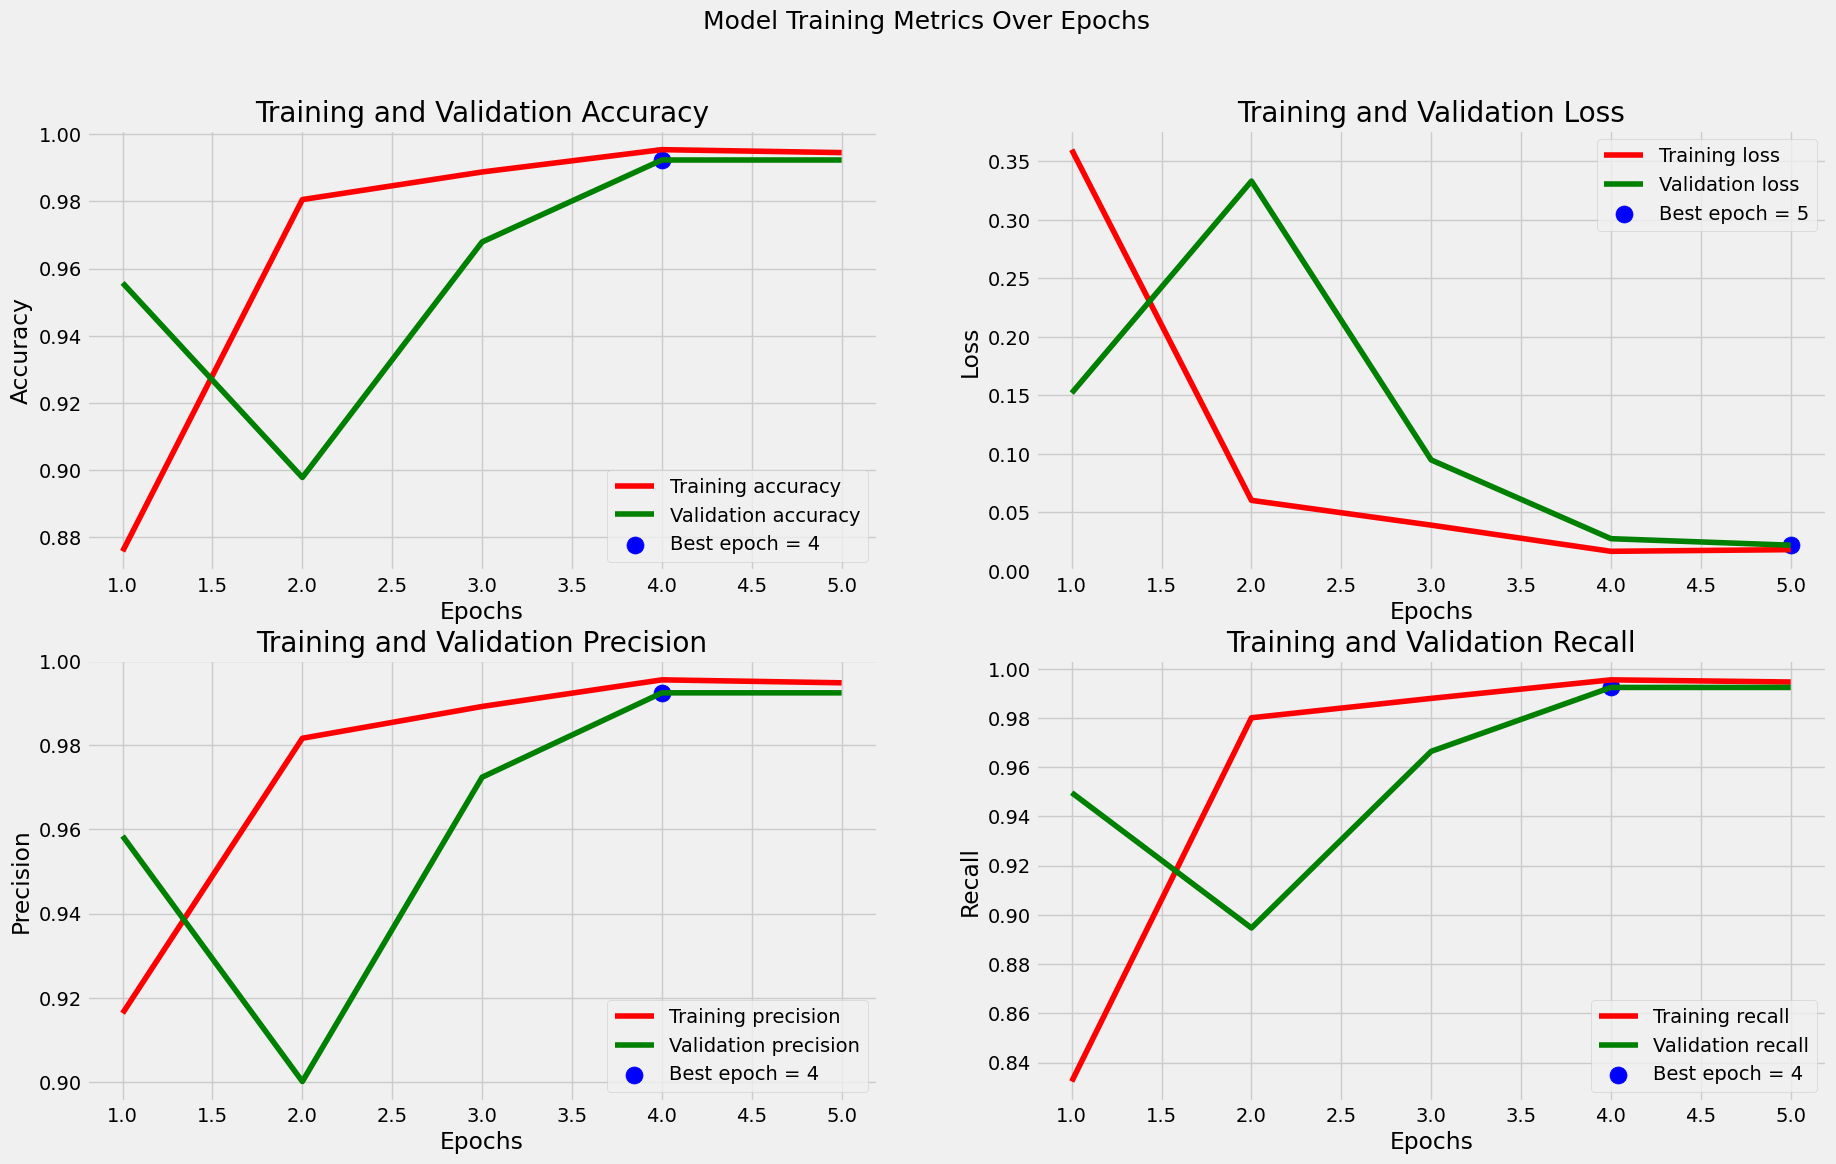

In [22]:

# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx+1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) +1)

  plt.plot(epochs, tr_metrics[metric], 'r', label = f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label = f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18)
plt.show()

In [24]:
# Evaluate the model performance
train_score = model.evaluate(tr_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(ts_fen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.9999 - loss: 0.0011 - precision: 0.9999 - recall: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9906 - loss: 0.0117 - precision: 0.9906 - recall: 0.9906
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 5.1438e-05 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9914 - loss: 0.0223 - precision: 0.9914 - recall: 0.9914
Train Accuracy: 99.98%
Train Loss: 0.0014


Validation Accuracy: 99.24%
Validation Loss: 0.0200


Test Accuracy: 98.78%
Test Loss: 0.0314


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


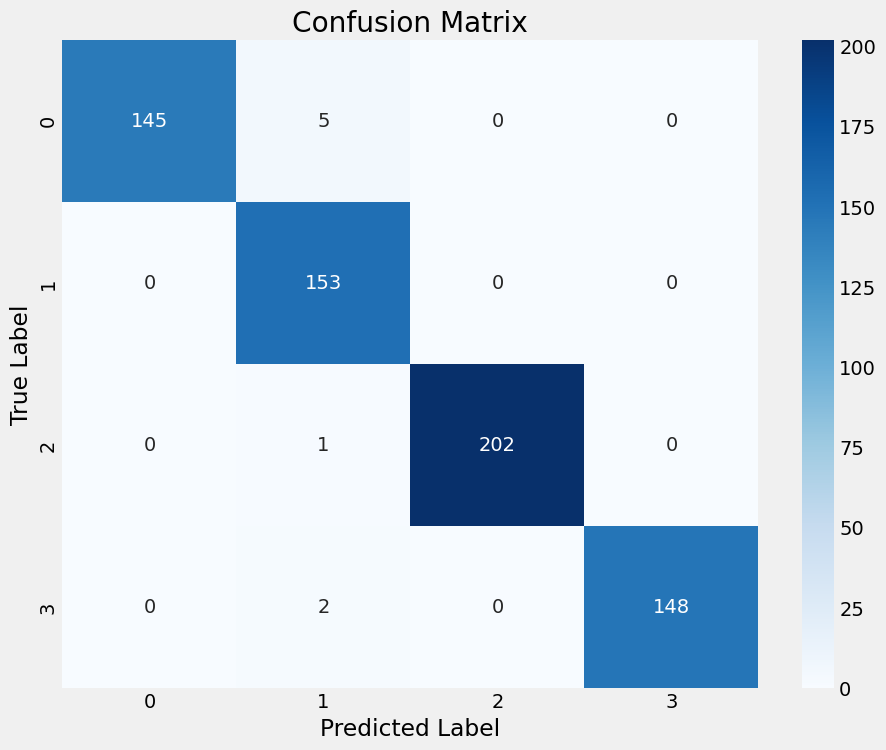

In [27]:
# Confusion matrix- way to check where the model succeeeds and makes mistakes
preds = model.predict(ts_fen)
y_pred = np.argmax(preds, axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# create and display the confusion matrix
cm = confusion_matrix(ts_fen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Visualize the predictions of the model on a few test images.
from PIL import Image

def predict(img_path: str) -> None:
  # Get the class labels
  labels = list(class_dict.keys())

  # create figure
  plt.figure(figsize=(6,8))

  # load and preprocess the image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis = 0) /255.0

  # get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # plot the original image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted:{predicted_class}")

  # plot prediction probabilities
  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize = 15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt = "%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor types: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


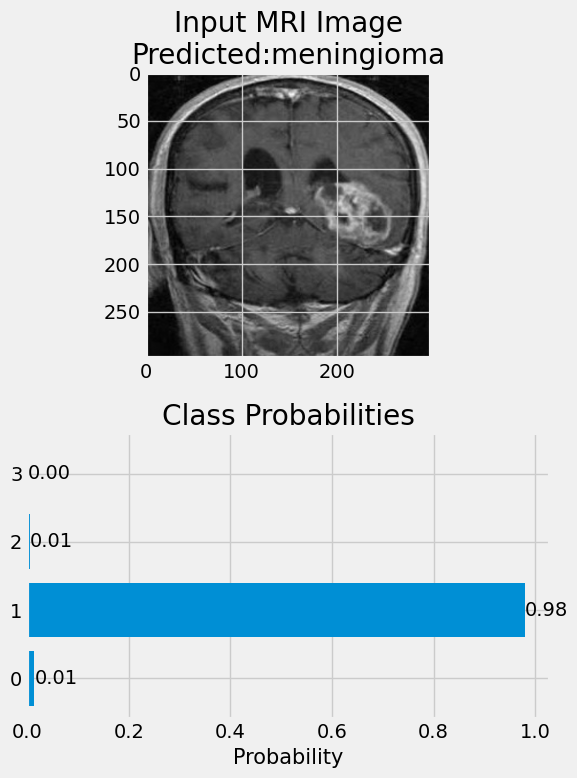


Predicted tumor types: meningioma


In [32]:
predict("/content/Testing/meningioma/Te-meTr_0007.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


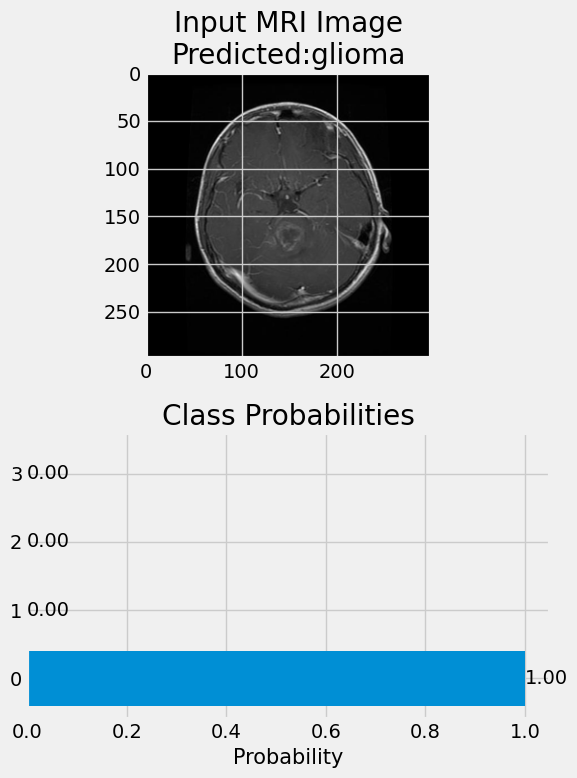


Predicted tumor types: glioma


In [33]:
predict("/content/Testing/glioma/Te-glTr_0007.jpg")

In [34]:
model.save_weights("xception_model.weights.h5")

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [15]:
batch_size = 16 #reduce the training time
img_size = (224, 224)

image_generator = ImageDataGenerator(rescale = 1/255, brightness_range = (0.8, 1.2))

ts_gen = ImageDataGenerator(rescale = 1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = "Class Path", y_col = "Class", batch_size = batch_size, target_size = img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col = "Class Path", y_col = "Class", batch_size = 16, target_size = img_size, shuffle = False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [18]:
# create a sequential model
cnn_model = Sequential()

# Convolutional layers
# 4 convolutional blocks with each block having different number of convolutional filters
# filters: each of them identify diff visual elements in an image like edges, textures or shapes
# filters: extracts features
cnn_model.add(Conv2D(512, (3,3), padding='same', input_shape = (224,224,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2))) #reduces dimensions of the image by taking just the prominent features of the image

cnn_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25)) #randomly turns off some connections to reduce overfitting

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) #64 filters to find the highest level of features
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax')) # output later with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# display model summary
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = cnn_model.fit(tr_gen, epochs = 8, validation_data= valid_gen)

Epoch 1/8
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 292ms/step - accuracy: 0.9355 - loss: 0.3070 - precision_1: 0.9404 - recall_1: 0.9335 - val_accuracy: 0.9176 - val_loss: 0.3190 - val_precision_1: 0.9202 - val_recall_1: 0.9160
Epoch 2/8
357/357 ━━━━━━━━━━━━━━━━━━━━ 104s 291ms/step - accuracy: 0.9481 - loss: 0.2708 - precision_1: 0.9497 - recall_1: 0.9446 - val_accuracy: 0.9359 - val_loss: 0.3020 - val_precision_1: 0.9413 - val_recall_1: 0.9298
Epoch 3/8
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 298ms/step - accuracy: 0.9570 - loss: 0.2270 - precision_1: 0.9597 - recall_1: 0.9535 - val_accuracy: 0.9298 - val_loss: 0.3275 - val_precision_1: 0.9310 - val_recall_1: 0.9267
Epoch 4/8
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 292ms/step - accuracy: 0.9644 - loss: 0.2067 - precision_1: 0.9656 - recall_1: 0.9633 - val_accuracy: 0.9420 - val_loss: 0.2916 - val_precision_1: 0.9449 - val_recall_1: 0.9420
Epoch 5/8
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 298ms/step - accuracy: 0.9662 - loss: 0.1955 - precision_1: 0.9674 - rec

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

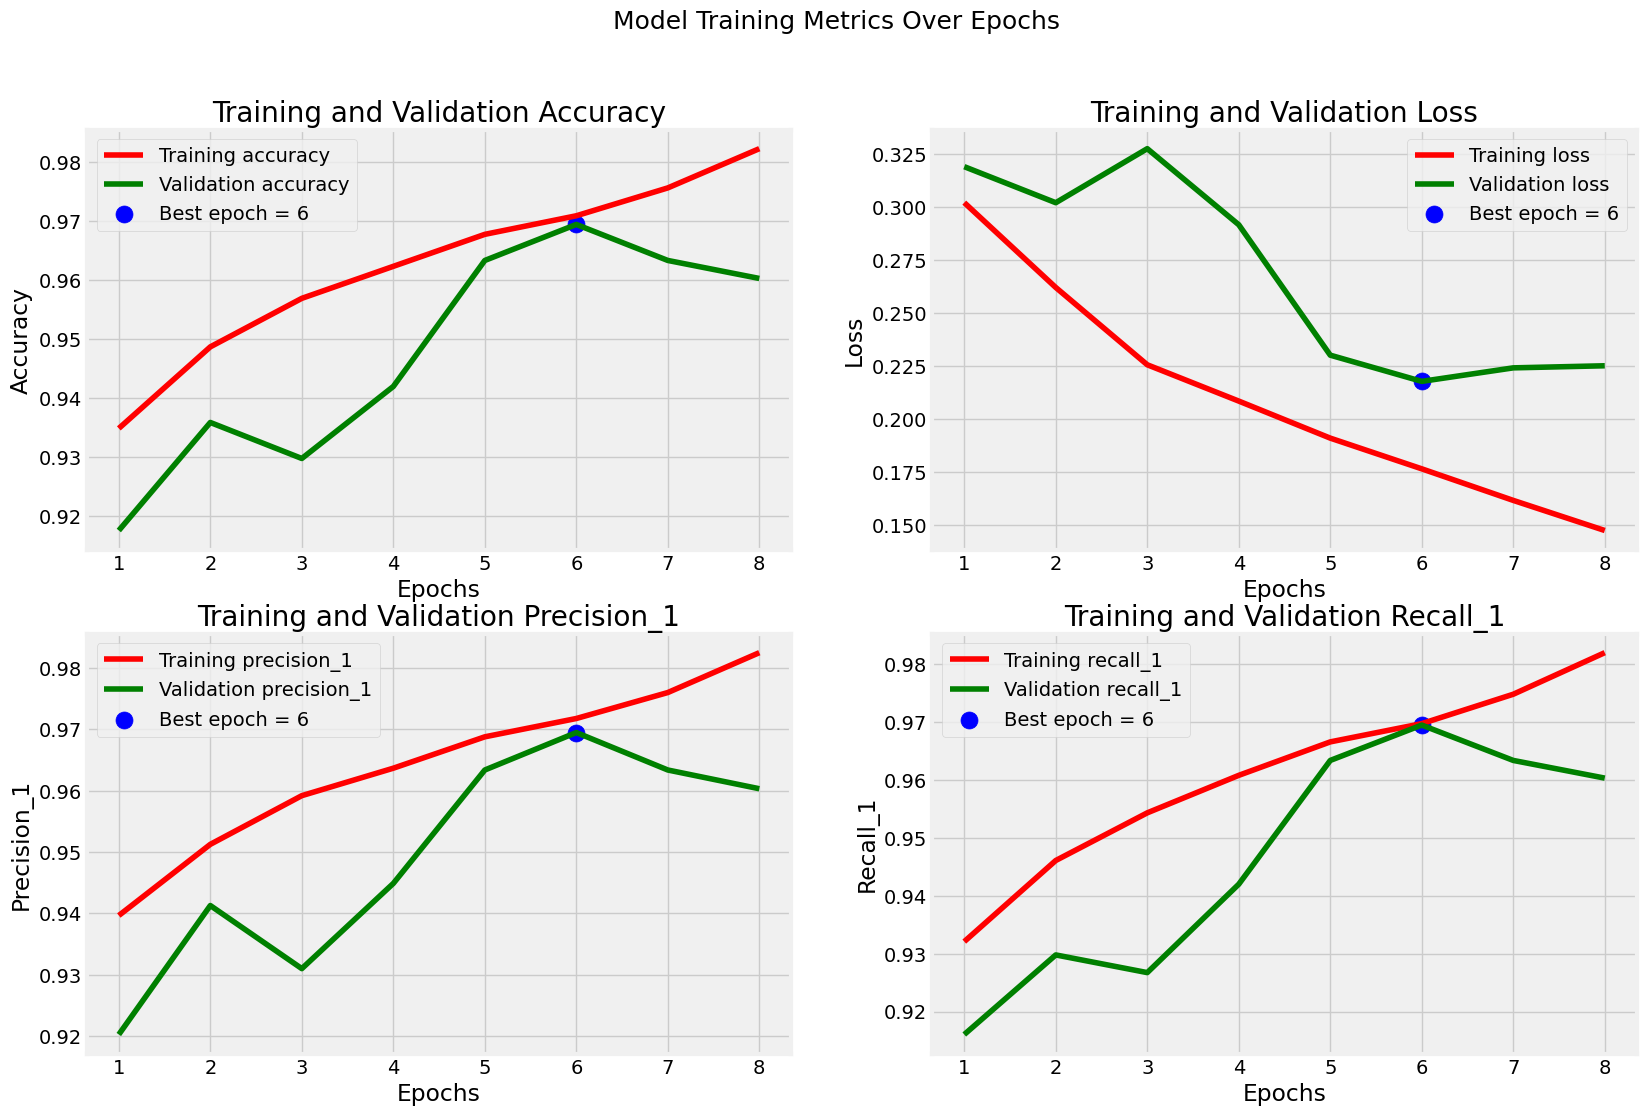

In [24]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision_1', 'recall_1']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx+1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) +1)

  plt.plot(epochs, tr_metrics[metric], 'r', label = f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label = f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18)
plt.show()

In [26]:
# Evaluate the cnn model performance
train_score = cnn_model.evaluate(tr_gen, verbose = 1)
valid_score = cnn_model.evaluate(valid_gen, verbose = 1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9944 - loss: 0.1124 - precision_1: 0.9946 - recall_1: 0.9944
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9540 - loss: 0.2252 - precision_1: 0.9543 - recall_1: 0.9540
 2/41 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 0.1008 - precision_1: 1.0000 - recall_1: 1.0000 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9765 - loss: 0.1787 - precision_1: 0.9765 - recall_1: 0.9765
Train Accuracy: 99.35%
Train Loss: 0.1139


Validation Accuracy: 96.03%
Validation Loss: 0.2218


Test Accuracy: 96.80%
Test Loss: 0.1955


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


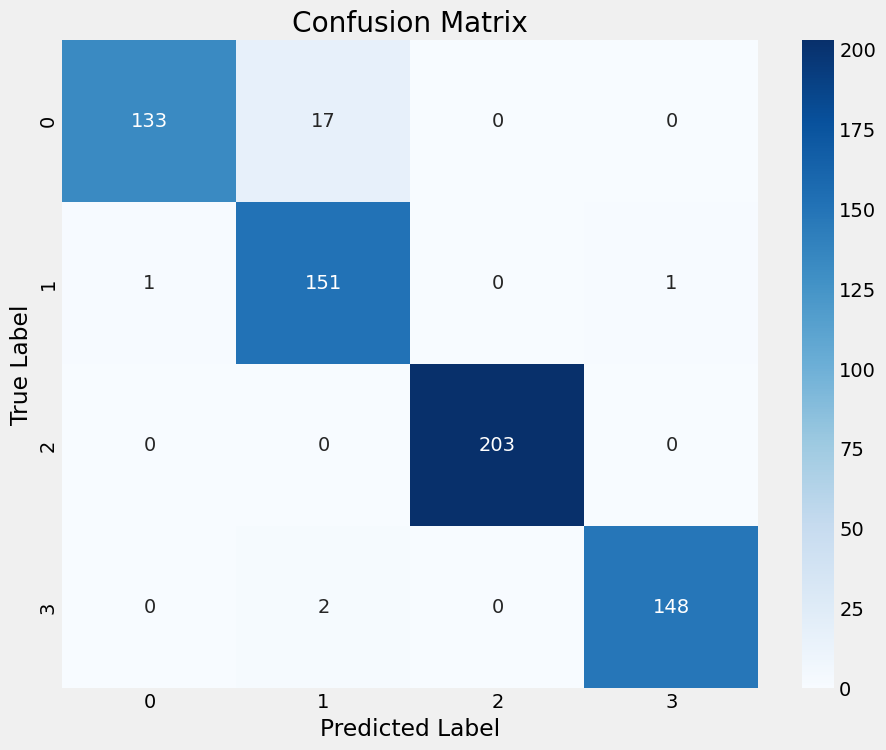

In [27]:
# Confusion matrix- way to check where the model succeeeds and makes mistakes
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       150
           1       0.89      0.99      0.93       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [30]:
cnn_model.save("cnn_model.h5")

# Part 2: Streamlit

In [ ]:
! pip install streamlit pyngrok python-dotenv

In [ ]:
from threading import thread
from pyngrok import ngrok
